In [11]:
# 用osmx构建street
# 用API 得到street对应的 meshblock
# 把street转成meshblock
# 根据street的邻居构建 meshblock 的边

In [12]:
import numpy as np
import requests
import osmnx as ox
import networkx as nx
import geopandas as gpd
import pandas as pd
import numpy as np

                                            geometry  bbox_north  bbox_south  \
0  POLYGON ((301997.266 -4082816.606, 302016.825 ...  -36.867678  -36.870725   

    bbox_east   bbox_west   place_id osm_type    osm_id        lat  \
0  174.779537  174.778569  118523389      way  48383821 -36.869262   

          lon                                       display_name    class  \
0  174.778972  Newmarket, Joseph Banks Terrace, Newmarket, Au...  railway   

      type  importance  
0  station    0.460255  


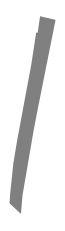

In [13]:
# Find Auckland location from osmx package
city = ox.geocode_to_gdf("NewMarket, Auckland, NZ")
city_proj = ox.project_gdf(city)
ax = city_proj.plot(fc="gray", ec="none")
_ = ax.axis("off")
print(city_proj)

In [14]:
highway_G = ox.graph_from_point(
    (-36.8679152, 174.7774390),
    dist=500,
    dist_type="network",
    network_type="walk",
    simplify=False,
    retain_all=True,
    custom_filter = '["highway"~"unclassified|trunk|primary|tertiary|secondary|track|path|residential"]'
)
print(highway_G)

MultiDiGraph with 344 nodes and 726 edges


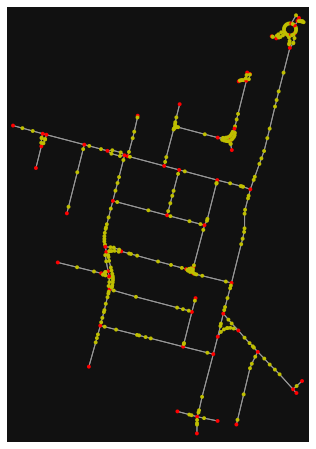

In [15]:
# turn off strict mode and see what nodes we'd remove, in yellow
nc = ["r" if ox.simplification._is_endpoint(highway_G, node) else "y" for node in highway_G.nodes()]
fig, ax = ox.plot_graph(highway_G, node_color=nc)

In [16]:
graph_nodes_df = pd.DataFrame.from_dict(dict(highway_G.nodes(data=True)), orient='index')
#nodes_df.loc[25771299]

In [17]:
def fetch_meshblock_from_api(shared_meshblock_dict, node_list, node_df):
    for s in node_list:
        if s in shared_meshblock_dict.keys():
            continue
        source_node = node_df.loc[s]
        # layer seems fixed, may need to change key from STATS NZ every first run
        request = requests.get('https://datafinder.stats.govt.nz/services/query/v1/vector.json/?v=1.2&key=54966b27e941479aad386087f7685ae9&layer=105176&x={x}&y={y}&radius=12&max_results=10&geometry=true&with_field_names=true'.format(x=source_node["x"],y=source_node["y"]))
        response = request.json()
        #print(response)

        layers = response['vectorQuery']['layers']
        # GET meshblock Id from API
        meshblock_id = ""
        for layer in layers.values():
            for feature in layer["features"]:
                meshblock_id = feature['properties']['MB2021_V1_00']
                break
            # found meshblock in first layer, stop
            if meshblock_id != "":
                break
        # replace node id to meshblock id
        shared_meshblock_dict[s] = meshblock_id
    return shared_meshblock_dict

In [18]:
def construct_source_and_target_nodes_from_graph(graph_G):
    source_list = []
    target_list = []
    for edge in graph_G.edges(data=True):
        u,v,data = edge
        source_list.append(u)
        target_list.append(v)
    return source_list,target_list

In [19]:
source_nodes_list,target_nodes_list = construct_source_and_target_nodes_from_graph(highway_G)

unique_source_nodes_list = np.unique(source_nodes_list)
unique_target_nodes_list = np.unique(target_nodes_list)

meshblock_mapping_dict={}
meshblock_mapping_dict = fetch_meshblock_from_api(meshblock_mapping_dict,unique_source_nodes_list,graph_nodes_df)
meshblock_mapping_dict = fetch_meshblock_from_api(meshblock_mapping_dict,unique_target_nodes_list,graph_nodes_df)

In [20]:
def replace_node_id_with_meshblock_id(node_list,mapping_dict):
    # using global dict to check
    mapping_keys = mapping_dict.keys()
    output_list = []
    for node in node_list:
        if node not in mapping_keys:
            output_list.append("-1")
        output_list.append(str(mapping_dict[node]))
    return output_list

In [29]:
# replace node with meshblock
source_meshblock_list = replace_node_id_with_meshblock_id(source_nodes_list,meshblock_mapping_dict)
target_meshblock_list = replace_node_id_with_meshblock_id(target_nodes_list,meshblock_mapping_dict)

In [32]:
zipped_meshblock_list = list(zip(source_meshblock_list, target_meshblock_list))
meshblock_edge_df = pd.DataFrame(zipped_meshblock_list,columns=["source","target"])
print(meshblock_edge_df.head(5))

    source   target
0  0450100  0450100
1  0450100  0450300
2  0450100  0450300
3  0450100  0450100
4  0450100  0451000


In [38]:
meshblock_edge_df = meshblock_edge_df.drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=False)
print(meshblock_edge_df.describe())
meshblock_edge_df.to_csv("./output/meshblock_edges.csv",header=False,index=False)

         source   target
count        75       75
unique       19       19
top     4000140  4000140
freq          7        7
